# LOAD THE LIBRARIES

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda update -n base -c defaults conda --yes

import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge
    sci

# LOAD THE FOURSQUARE ACCESS

In [2]:
CLIENT_ID ='RZWMX0S2LSGN22GQGSOUIUTL0ZGJ2YIZAEDFEDO5EOWPZ3ML'
CLIENT_SECRET ='I0RE3O3UGNUJIWU4P23RAWV2HE3I3NL1BUGUAWOTA3H21ZPD'

#CLIENT_ID = 'PASDARXFDIT0AJUVQKOWZGUFI3YONQJCJEPPIRT0QVBIMYU5' # your Foursquare ID
#CLIENT_SECRET = 'LPGZ5S1AUEBNIWNHG1AOEK0CDIMUEONPLXC0KIZKAWS4LEAG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
print('My credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentials:
CLIENT_ID: RZWMX0S2LSGN22GQGSOUIUTL0ZGJ2YIZAEDFEDO5EOWPZ3ML
CLIENT_SECRET:I0RE3O3UGNUJIWU4P23RAWV2HE3I3NL1BUGUAWOTA3H21ZPD


# LOAD THE PRIMARY DATAFILE

## EXTRACTED FROM https://en.wikipedia.org/wiki/List_of_Perth_suburbs & https://quickstats.censusdata.abs.gov.au/census_services/getproduct/census/2016/quickstat/SSC51218
## TRANSFORMED INTO EXCEL CSV DATASHEET & IMPORTED


In [3]:
perthdata = pd.read_csv("Perth_WA_Suburbs_Data.csv")
# Preview the first 10 lines of the loaded data 
perthdata.head(5)

,Suburb,Borough,Perth Area,Population
0,Alexander Heights,Wanneroo,NaN,7821
1,Alfred Cove,Melville,Inner South West,2192
2,Alkimos,Wanneroo,NaN,6269
3,Anketell,Kwinana,NaN,234
4,Applecross,Melville,Inner South West,5693


# CLEAN THE DATA BY REMOVING UNNECESSARY COLUMNS

In [4]:
perthdata2=perthdata.drop('Perth Area', axis='columns')
perthdata2.head(5)

,Suburb,Borough,Population
0,Alexander Heights,Wanneroo,7821
1,Alfred Cove,Melville,2192
2,Alkimos,Wanneroo,6269
3,Anketell,Kwinana,234
4,Applecross,Melville,5693


# LOAD THE POSTAL CODES FILE FROM http://www.corra.com.au/australian-postcode-location-data/ AND APPEND THE LAT AND LONG TO THOSE IN THE ABOVE DATA FILE.  
##  CLEAN THE DATA TO REMOVE OF ANY BLANK LAT AND LONG FIELDS AND ANY POSTAL CODES AREAS THAT DO NOT ALIGN WITH A PERTH SUBURB

In [5]:
latlongdata = pd.read_csv("perthlatlongdata.csv")
latlongdata = latlongdata.round({"Latitude":6, "Longitude":6})
latlongdata.head(5)

,Suburb,Latitude,Longitude
0,Alexander Heights,-31.835333,115.849098
1,Alfred Cove,-32.040061,115.825994
2,Alkimos,NaN,NaN
3,Anketell,-32.223657,115.835308
4,Applecross,-32.024363,115.837525


In [6]:
latlongdata.rename(columns={'Postal Area':'Suburb'},inplace=True)
perthdata3 = pd.merge(perthdata2,latlongdata, on=['Suburb'])
perthdata3 = perthdata3.dropna()
perthdata3 = perthdata3.sort_values(['Suburb'])
perthdata4 = perthdata3.reset_index(drop=True)

perthdata4.head(5)

,Suburb,Borough,Population,Latitude,Longitude
0,Alexander Heights,Wanneroo,7821,-31.835333,115.849098
1,Alfred Cove,Melville,2192,-32.040061,115.825994
2,Anketell,Kwinana,234,-32.223657,115.835308
3,Applecross,Melville,5693,-32.024363,115.837525
4,Ardross,Melville,3516,-32.024363,115.837525


# SAVE THE DATA SET AS A FILE FOR LATER USE

In [7]:
perthdata4.to_csv("Perthdata.csv")

# SET UP THE MAP - THE CENTRE WILL BE THE SUBURB OF PERTH CITY

In [8]:
perthcity = perthdata4[perthdata4['Suburb']==('Perth City')].reset_index(drop=True)
suburb_lat = perthcity.loc[0, 'Latitude'] # suburb latitude value
suburb_long = perthcity.loc[0, 'Longitude'] # suburb longitude value
suburb_name = perthcity.loc[0, 'Suburb'] # neighborhood name
print('Latitude and longitude values of {} are {}, {}.'.format(suburb_name, 
                                                               suburb_lat, 
                                                               suburb_long))

Latitude and longitude values of Perth City are -31.948762, 115.859912.


# USE FOURSQUARE TO IDENTIFY VENUES WITHIN A 30KM RADIUS OF PERTH CITY
## THE RADIUS OF 30KM HAS BEEN CHOSEN BECAUSE OF THE SIZE OF THE GREATER PERTH LOCATION AND RELATIVELY SPARSE POPULATION DENSITY

In [9]:
search_query = 'Perth City'
radius = 30000
LIMIT= 1000

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, suburb_lat, suburb_long, VERSION, radius, LIMIT)
results = requests.get(url).json()

# EXPLORE VENUE DETAILS

In [10]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [11]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
nearby_venues.head()

100 venues were returned by Foursquare.


,name,categories,lat,lng
0,Toastface Grillah,Sandwich Place,-31.952441,115.860964
1,Chicho Gelato,Ice Cream Shop,-31.949600,115.859009
2,Varnish on King,Whisky Bar,-31.950952,115.855536
3,Frisk. Small Bar,Cocktail Bar,-31.946565,115.856706
4,Le Vietnam,Vietnamese Restaurant,-31.954256,115.860512


In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
       # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
         
    return(nearby_venues)
nearby_venues.head()

,name,categories,lat,lng
0,Toastface Grillah,Sandwich Place,-31.952441,115.860964
1,Chicho Gelato,Ice Cream Shop,-31.949600,115.859009
2,Varnish on King,Whisky Bar,-31.950952,115.855536
3,Frisk. Small Bar,Cocktail Bar,-31.946565,115.856706
4,Le Vietnam,Vietnamese Restaurant,-31.954256,115.860512


In [13]:
perthvenues = getNearbyVenues(names=perthdata4['Suburb'],
                                latitudes=perthdata4['Latitude'],
                                longitudes=perthdata4['Longitude'])

# THIS SECTION BREAKS DOWN ALL THE VENUES INTO THEIR CATEGORIES.  
# WE ARE INTERESTED IN THE SHOPPING MALLS AND PLAZA VENUES ONLY

In [14]:
print(perthvenues.shape)
perthvenues.head(10) 

(3228, 7)


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alexander Heights,-31.835333,115.849098,Domino's Pizza,-31.830509,115.853342,Pizza Place
1,Alexander Heights,-31.835333,115.849098,Alexander Heights Shopping Centre,-31.829769,115.853448,Shopping Mall
2,Alexander Heights,-31.835333,115.849098,Red Rooster,-31.830807,115.853138,Fast Food Restaurant
3,Alexander Heights,-31.835333,115.849098,Cradle Props,-31.840754,115.849288,Photography Studio
4,Alexander Heights,-31.835333,115.849098,Video Ezy - Alexander Heights,-31.830601,115.853329,Video Store
5,Alexander Heights,-31.835333,115.849098,Paloma Sk8 Park,-31.829711,115.851570,Skate Park
6,Alexander Heights,-31.835333,115.849098,Liquorland,-31.830309,115.853543,Liquor Store
7,Alexander Heights,-31.835333,115.849098,Coles,-31.830137,115.854053,Supermarket
8,Alexander Heights,-31.835333,115.849098,Suria Cafe,-31.838613,115.839627,Asian Restaurant
9,Alfred Cove,-32.040061,115.825994,Melville Aquatic Centre,-32.039364,115.830950,Water Park


In [15]:
perthvenues.groupby(["Suburb"]).count()
perthvenues.head(10)

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alexander Heights,-31.835333,115.849098,Domino's Pizza,-31.830509,115.853342,Pizza Place
1,Alexander Heights,-31.835333,115.849098,Alexander Heights Shopping Centre,-31.829769,115.853448,Shopping Mall
2,Alexander Heights,-31.835333,115.849098,Red Rooster,-31.830807,115.853138,Fast Food Restaurant
3,Alexander Heights,-31.835333,115.849098,Cradle Props,-31.840754,115.849288,Photography Studio
4,Alexander Heights,-31.835333,115.849098,Video Ezy - Alexander Heights,-31.830601,115.853329,Video Store
5,Alexander Heights,-31.835333,115.849098,Paloma Sk8 Park,-31.829711,115.851570,Skate Park
6,Alexander Heights,-31.835333,115.849098,Liquorland,-31.830309,115.853543,Liquor Store
7,Alexander Heights,-31.835333,115.849098,Coles,-31.830137,115.854053,Supermarket
8,Alexander Heights,-31.835333,115.849098,Suria Cafe,-31.838613,115.839627,Asian Restaurant
9,Alfred Cove,-32.040061,115.825994,Melville Aquatic Centre,-32.039364,115.830950,Water Park


In [16]:
#one hot encoding

perthonehot = pd.get_dummies(perthvenues[['Venue Category']], prefix="", prefix_sep="")
                                               
# add neighborhood column back to dataframe 
                                               
perthonehot['Suburb'] = perthvenues['Suburb']
                                               
# move neighborhood column to the first column
                                               
fixed_columns = [perthonehot.columns[-1]] + list(perthonehot.columns[:-1])  
                                               
perthonehot = perthonehot[fixed_columns]
                                               
perthonehot.head()

,Suburb,African Restaurant,Airport,Airport Terminal,Alternative Healer,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bakery,Bar,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Boat or Ferry,Bookstore,Bowling Alley,Bowling Green,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Café,Candy Store,Cantonese Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Quad,College Technology Building,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Event Service,Factory,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,History Museum,Hockey Field,Home Service,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Laser Tag,Laundromat,Lebanese Restaurant,Liquor Store,Lounge,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Night Market,Nightclub,Noodle House,Other Great Outdoors,Other Nightlife,Paintball Field,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Post Office,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Roller Rink,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soccer Stadium,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Train Station,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Alexander Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Alexander Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Alexander Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

# THIS SECTION EXPLORES THE STATISTICAL RELATIONSHIP OF VENUE CATEGORIES WITHIN EACH SUBURB
## 244 SUBURBS CONTAINING 204 VENUE CATEGORIES

In [17]:
perthgrouped = perthonehot.groupby(["Suburb"]).mean().reset_index()
print(perthgrouped.shape)
perthgrouped.head(5)

(244, 203)


,Suburb,African Restaurant,Airport,Airport Terminal,Alternative Healer,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bakery,Bar,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Boat or Ferry,Bookstore,Bowling Alley,Bowling Green,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Café,Candy Store,Cantonese Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Quad,College Technology Building,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Event Service,Factory,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,History Museum,Hockey Field,Home Service,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Laser Tag,Laundromat,Lebanese Restaurant,Liquor Store,Lounge,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Night Market,Nightclub,Noodle House,Other Great Outdoors,Other Nightlife,Paintball Field,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Post Office,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Roller Rink,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soccer Stadium,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Train Station,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Alexander Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,Alfred Cove,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.052632,0.00,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0

# THE NUMBER OF MALLS IN PERTH IS:

In [18]:
len(perthgrouped[perthgrouped["Shopping Mall"] > 0])

73

# LIST THE SUBURNS WITH SHOPPING MALLS

In [19]:
perthmall = perthgrouped[["Suburb","Shopping Mall"]]
perthmall.head()

,Suburb,Shopping Mall
0,Alexander Heights,0.111111
1,Alfred Cove,0.052632
2,Applecross,0.000000
3,Ardross,0.000000
4,Armadale,0.000000


# CONDUCT ELBOW METHOD CHECK TO ASSESS CLUSTER SIZE BASED ON NUMBER OF SHOPPING MALLS

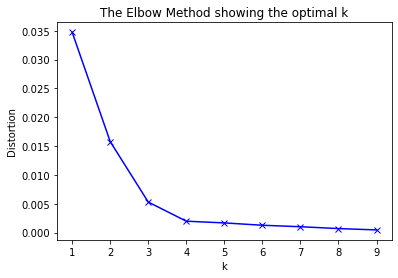

In [20]:
# determine k using elbow method
# clustering dataset
perthclustering = perthmall.drop(["Suburb"], 1)

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(perthclustering)
    kmeanModel.fit(perthclustering)
    distortions.append(sum(np.min(cdist(perthclustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / perthclustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


# THIS SECTION CLUSTERS THE MALLS AND PLAZAS INTO 4 CLUSTERS

In [21]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(perthclustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:5]

array([3, 2, 0, 0, 0], dtype=int32)

In [22]:
# create a new dataframe that includes the cluster
perthmerged = perthmall.copy()

# add clustering labels
perthmerged["Cluster Labels"] = kmeans.labels_
perthmerged.head()


,Suburb,Shopping Mall,Cluster Labels
0,Alexander Heights,0.111111,3
1,Alfred Cove,0.052632,2
2,Applecross,0.000000,0
3,Ardross,0.000000,0
4,Armadale,0.000000,0


# THE FINAL DATA SET OF ALL SUBURBS WITH MALLS AND THEIR LATITUDE, LONGITUDE AND POPULATION

In [23]:
# merge perthmerged with perthdata to add latitude/longitude for each neighborhood
result=[]
result = pd.merge(perthmerged, perthdata4[['Suburb','Latitude', 'Longitude','Population']], on='Suburb')
perthmerged = result
perthmerged.head()

,Suburb,Shopping Mall,Cluster Labels,Latitude,Longitude,Population
0,Alexander Heights,0.111111,3,-31.835333,115.849098,7821
1,Alfred Cove,0.052632,2,-32.040061,115.825994,2192
2,Applecross,0.000000,0,-32.024363,115.837525,5693
3,Ardross,0.000000,0,-32.024363,115.837525,3516
4,Armadale,0.000000,0,-32.158675,115.997934,20101


# THIS SECTION BREAKS THE DATA INTO 3 SUB-SETS BASED ON POPULATION
## SUBURBS WITH A POPULATION OF >5000 AS BELOW THIS FIGURE A SUBURB MAY BE CONSIDERED TOO SMALL TO SUPPORT A MALL.  
## SUBURBS WITH A POPULATION OF >10000
## SUBURBS WITH A POPULATION OF >20000 
## EACH IS VISUALIZED ONTO THE PERTH MAP.

In [24]:
# sort the results by Cluster Labels
perthmerged.sort_values(["Cluster Labels","Suburb"], inplace=True)
perthmerged_5000 = perthmerged.drop(perthmerged[perthmerged.Population < 5000].index)
perthmerged_5000.head()

,Suburb,Shopping Mall,Cluster Labels,Latitude,Longitude,Population
2,Applecross,0.0,0,-32.024363,115.837525,5693
4,Armadale,0.0,0,-32.158675,115.997934,20101
7,Attadale,0.0,0,-32.039540,115.800233,5117
10,Balcatta,0.0,0,-31.871671,115.811933,9030
11,Baldivis,0.0,0,-32.328863,115.833257,34129


## SET UP THE MAP

In [25]:
address = 'Perth, Western Australia'
geolocator = Nominatim(user_agent="t_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Perth Western Australia {}, {}.'.format(latitude, longitude))

The geographical coordinates of Perth Western Australia -31.9527121, 115.8604796.


# MAP 1

In [26]:
# create map
perth5000map = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(perthmerged_5000['Latitude'], perthmerged_5000['Longitude'], perthmerged_5000['Suburb'], perthmerged_5000['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(perth5000map)
       
perth5000map

In [27]:
# save the map as HTML file
perth5000map.save('perth5000map.html')

# MAP 2

In [28]:
# sort the results by Cluster Labels
perthmerged.sort_values(["Cluster Labels","Suburb"], inplace=True)
perthmerged_10000 = perthmerged.drop(perthmerged[perthmerged.Population < 10000].index)
perthmerged_10000.head()

,Suburb,Shopping Mall,Cluster Labels,Latitude,Longitude,Population
4,Armadale,0.0,0,-32.158675,115.997934,20101
11,Baldivis,0.0,0,-32.328863,115.833257,34129
13,Ballajura,0.0,0,-31.842690,115.896508,19784
19,Bayswater,0.0,0,-31.920863,115.914851,11396
39,Canning Vale - East,0.0,0,-32.061501,115.890779,23891


In [29]:
# create map
perthmap10000 = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(perthmerged_10000['Latitude'], perthmerged_10000['Longitude'], perthmerged_10000['Suburb'], perthmerged_10000['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(perthmap10000)
       
perthmap10000

In [30]:
# save the map as HTML file
perthmap10000.save('perthmap10000.html')

In [31]:
# sort the results by Cluster Labels
perthmerged.sort_values(["Cluster Labels","Suburb"], inplace=True)
perthmerged_20000 = perthmerged.drop(perthmerged[perthmerged.Population < 20000].index)
perthmerged_20000.head()

,Suburb,Shopping Mall,Cluster Labels,Latitude,Longitude,Population
4,Armadale,0.0,0,-32.158675,115.997934,20101
11,Baldivis,0.0,0,-32.328863,115.833257,34129
39,Canning Vale - East,0.0,0,-32.061501,115.890779,23891
85,Gosnells,0.0,0,-32.078535,116.008603,20845
136,Mandurah,0.0,0,-32.557981,115.728286,96738


In [32]:
# create map
perthmap20000 = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(perthmerged_20000['Latitude'], perthmerged_20000['Longitude'], perthmerged_20000['Suburb'], perthmerged_20000['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(perthmap20000)
       
perthmap20000

In [33]:
# save the map as HTML file
perthmap20000.save('perthmap20000.html')

# THIS SECTION ANALYSES THE DETAIL WITHIN EACH CLUSTER FOR SUBURBS WITH POPULATIONS GREATER THAN 5000.

In [34]:
perthmerged_5000.loc[perthmerged_5000['Cluster Labels'] == 0]

,Suburb,Shopping Mall,Cluster Labels,Latitude,Longitude,Population
2,Applecross,0.000000,0,-32.024363,115.837525,5693
4,Armadale,0.000000,0,-32.158675,115.997934,20101
7,Attadale,0.000000,0,-32.039540,115.800233,5117
10,Balcatta,0.000000,0,-31.871671,115.811933,9030
11,Baldivis,0.000000,0,-32.328863,115.833257,34129
12,Balga,0.000000,0,-31.864113,115.843478,8909
13,Ballajura,0.000000,0,-31.842690,115.896508,19784
15,Banksia Grove,0.000000,0,-31.692538,115.772138,9350
17,Bassendean,0.000000,0,-31.901801,115.942572,8522
19,Bayswater,0.000000,0,-31.920863,115.914851,11396


In [35]:
perthmerged_5000.loc[perthmerged_5000['Cluster Labels'] == 1]

,Suburb,Shopping Mall,Cluster Labels,Latitude,Longitude,Population
24,Beechboro,0.200000,1,-31.866822,115.937824,18896
30,Bibra Lake,0.166667,1,-32.084784,115.798722,5474
56,Coolbellup,0.166667,1,-32.084784,115.798722,8369
95,Heathridge,0.166667,1,-31.763347,115.756405,7086
112,Joondalup,0.166667,1,-31.763347,115.756405,7007
116,Kardinya,0.166667,1,-32.084784,115.798722,9062
158,Mullaloo,0.166667,1,-31.763347,115.756405,5953
171,Ocean Reef,0.166667,1,-31.763347,115.756405,8136
206,Spearwood,0.166667,1,-32.084784,115.798722,10488


In [36]:
perthmerged_5000.loc[perthmerged_5000['Cluster Labels'] == 2]

,Suburb,Shopping Mall,Cluster Labels,Latitude,Longitude,Population
9,Aubin Grove,0.041667,2,-32.131993,115.854584,6324
14,Banjup,0.041667,2,-32.131993,115.854584,18056
31,Bicton,0.040000,2,-32.038228,115.783732,5860
32,Booragoon,0.052632,2,-32.040061,115.825994,15066
51,Clarkson,0.047619,2,-31.687341,115.711684,13459
59,Craigie,0.038462,2,-31.795830,115.754405,6033
65,Doubleview,0.047619,2,-31.891957,115.786821,6601
92,Hamilton Hill,0.041667,2,-32.131993,115.854584,10818
102,Hillarys,0.038462,2,-31.795830,115.754405,11355
108,Innaloo,0.047619,2,-31.891957,115.786821,5504


In [37]:
perthmerged_5000.loc[perthmerged_5000['Cluster Labels'] == 3]

,Suburb,Shopping Mall,Cluster Labels,Latitude,Longitude,Population
0,Alexander Heights,0.111111,3,-31.835333,115.849098,7821
81,Girrawheen,0.111111,3,-31.835333,115.849098,9035
88,Greenwood,0.111111,3,-31.834890,115.803068,10047
138,Marangaroo,0.111111,3,-31.835333,115.849098,10884
190,Safety Bay,0.100000,3,-32.338504,115.763949,7730
194,Scarborough,0.090909,3,-31.907330,115.769183,16493
215,Thornlie,0.111111,3,-32.060890,115.953584,23987
221,Waikiki,0.100000,3,-32.338504,115.763949,12785
222,Warnbro,0.100000,3,-32.338504,115.763949,11488
229,Wembley Downs,0.090909,3,-31.907330,115.769183,5414


In [38]:
# THIS SECTION USES MARKERS TO INDICATE THE POPULATION DENSITY ACROSS THE PERTH REGION

In [39]:
perthpopmap = folium.Map(location=[latitude, longitude], zoom_start=10)

#Function to change the marker color according to the population 

def color(pop): 
    if pop in range(0,999): 
        col = 'green'
    elif pop in range(1000,4999): 
        col = 'blue'
    elif pop in range(5000,9999): 
        col = 'orange'
    else: 
        col='red'
    return col
      
# Iterating over the LAT,LON,NAME and 
# ELEV columns simultaneously using zip() 

for lat,lan,name,pop in zip(perthmerged['Latitude'], perthmerged['Longitude'], perthmerged['Suburb'], perthmerged['Population']): 
    # Marker() takes location coordinates  
    # as a list as an argument 
    folium.Marker(location=[lat,lan],popup = name, 
                 icon= folium.Icon(color=color(pop), 
                 icon_color='yellow',icon='cloud')).add_to(perthpopmap) 
                    
# Save the file created above 
perthpopmap


In [40]:
perthpopmap.save('perthpopmap.html')

In [56]:
perthpopmap2 = folium.Map(location=[latitude, longitude], zoom_start=10)

#Function to change the marker color  
# according to the population 

def color(pop): 
    if pop in range(0,999): 
        col = 'yellow'
    elif pop in range(1000,4999): 
        col = 'blue'
    elif pop in range(5000,9999): 
        col = 'orange'
    else: 
        col='red'
    return col

def rad(pop): 
    if pop in range(0,999): 
        rad = '5'
    elif pop in range(1000,4999): 
        rad = '10'
    elif pop in range(5000,9999): 
        rad = '15'
    else: 
        rad = '20'
    return rad
      
for lat,lan,name,pop in zip(perthdata4['Latitude'], perthdata4['Longitude'], perthdata4['Suburb'], perthdata4['Population']): 
    # Marker() takes location coordinates  
    # as a list as an argument 
    folium.CircleMarker(location=[lat,lan], 
                 popup = folium.Popup(str(name) + ' - Population ' + str(pop), parse_html=True),
                 radius = rad(pop),  
                 color=color(pop),
                 fill=True, 
                 fill_color=color(pop),
                 fill_opacity=0.7
                 ).add_to(perthpopmap2) 
  
    # Save the file created above 

perthpopmap2

In [42]:
perthpopmap2.save('perthpopmap2.html')

In [43]:
# PRODUCE A HEAT MAP FOR THE GREATER PERTH AREA TO SHOW POPULATION DENSITY

In [44]:
# download countries geojson file
!wget --quiet  https://raw.githubusercontent.com/tonywr71/GeoJson-Data/master/suburb-10-wa.geojson -O perth_suburbs.json
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [57]:
from pprint import pprint

with open('perth_suburbs.json') as json_data:
    perth_data = json.load(json_data)
    print('Data read ok!')

Data read ok!


suburbs_data = perth_data['features']
suburbs_data[0]

In [58]:
perthnew = perthdata4
perthnew['Suburb'] = perthnew['Suburb'].str.upper() 
perthnew["Population"] = pd.to_numeric(perthnew["Population"].astype('int'))
perthnew = perthnew.round({"Population":0})
perthnew.to_csv("Perthnew.csv")
perthnew.head()

,Suburb,Borough,Population,Latitude,Longitude
0,ALEXANDER HEIGHTS,Wanneroo,7821,-31.835333,115.849098
1,ALFRED COVE,Melville,2192,-32.040061,115.825994
2,ANKETELL,Kwinana,234,-32.223657,115.835308
3,APPLECROSS,Melville,5693,-32.024363,115.837525
4,ARDROSS,Melville,3516,-32.024363,115.837525


# SET A HEAT MAP BASED ON POPULATION DENSITY

In [59]:
# download countries geojson file
!wget --quiet  https://raw.githubusercontent.com/tonywr71/GeoJson-Data/master/suburb-10-wa.geojson -O perth_suburbs.json
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [60]:
world_geo = r'perth_suburbs.json' # geojson file

# create a plain world map

perth_map = folium.Map(location=[latitude, longitude], zoom_start=10,tiles='Stamen Terrain')
perth_map

In [ ]:
# generate choropleth map using the Population of Western Australia

perth_map.choropleth(
    geo_data=world_geo,
    data=perthnew,
    columns=['Suburb', 'Population'],
    key_on='feature.properties.wa_local_2',
    fill_color='Reds', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population',
    reset=True,
    #threshold_scale = [0,5000, 20000, 100000]
    )

# display map
perth_map


In [ ]:
# add markers to the map
markers_colors = []
for lat, lon, poi in zip(perthnew['Latitude'], perthnew['Longitude'], perthnew['Suburb']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='Bu',
        fill=True,
        fill_color='Bu',
        fill_opacity=0.7).add_to(perth_map)

# display map
perth_map

perth_map.save('perth_map.html')